<h2><span style="background-color:grey; color:white; padding: 5px;">Cellules à executer dans Colab</span></h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mlflow pymysql pip install xgboost

In [ ]:
from drive.MyDrive.PCO.function import *
import pandas as pd

<h2><span style="background-color:grey; color:white; padding: 5px;">Choix des paramètres pour l'entraînement, le stockage sur MLflow et des données à récupérer.</span></h2>

In [16]:
# À executer en local uniquement :
from functions2 import *
import pandas as pd

In [17]:
#//////////////////////////////////////////////////////////////////////////////
#                       Option de filtrage des données
#//////////////////////////////////////////////////////////////////////////////
# Variable permettant de choisir si on veut traiter les outliers
gestion_outliers =True

# Nombre de ventes minimum sur une commune pour calculer un prix moyen au m² par commune
nb_ventes_mini = 10

# Taux de filtrage :
# - Le premier élément est le nombre de vente minimum par commune
# - Le deuxième élément est le pourcentage de outliers dans une commune
#
# Exemple pour tx_filtrage =[10,30] les lignes qui seront conservées seront :
# Les communes dans lesquelles il restera minimum 10 ventes après suppression des outliers
# ET  moins de 30% d'outliers
# ET les lignes inférieures à la limite des outliers
# tx_filtrage = [0,100] => Suppression des lignes dont le montant est au dessus de la limite des outliers.
tx_filtrage =[nb_ventes_mini,30]

# Recherche sur une région spécifique si recherche sur toute la France mettre ''
region=''

# Recherche sur un type de bien spécifique si recherche sur tous les bien mettre ''
type_de_bien ='Maison'

# Inclure la surface du terrain True ou False
surface_terrain = True

# Nombre de mois pour l'entraînement et le test (train=80% test= 20%)
# Exemple si 15 mois environ 12 mois pour l'entraînement et 3 mois pour le test
# Mettre None pour utiliser toutes les données disponible
nb_mois=15

#*******************************************************************************
#*******************  Pour ajouter d'autres variables :  ***********************
#*********  modifier la requête dans la fonction construction_requete() ********
#*******************************************************************************

#//////////////////////////////////////////////////////////////////////////////
#                       Configuration de XGBoost avec GridSearchCV
#//////////////////////////////////////////////////////////////////////////////
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'learning_rate': [0.1],
    'min_child_weight': [5],
    'lambda' : [0.5],
    'alpha' : [0.5]
}
cv=5

#//////////////////////////////////////////////////////////////////////////////
#                       Configuration de mlfow
#//////////////////////////////////////////////////////////////////////////////
# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "XGBoostRegressor"

# runs à effectuer all_datas 15months all_datas_surface_terrain 15months_surface_terrain)
run_name = f"{region}_{'Appartement_Maison' if len(type_de_bien)==0 else type_de_bien}"\
     f"_{nb_mois}months_GridSearch_GestionOutliers_{'oui' if gestion_outliers==True else 'non'}"\
     f"_{'' if surface_terrain==False else 'surface_terrain'}_alpha_lambda"

model_name = f"XGB_{run_name}"

<h2><span style="background-color:grey; color:white; padding: 5px;">Création de la requête </span></h2>

In [18]:
where_clause, query = construcion_requete(region,
                        type_de_bien,
                        nb_ventes_mini,
                        surface_terrain,
                        nb_mois)
print(query)


    # Table pour compter le nombre de ventes par commune
    WITH nb_ventes_mini AS(
    SELECT
        ID_COMMUNE AS ID_COMMUNE,
        count(*) nb_ventes_par_commune
    FROM VENTES 
    WHERE DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    GROUP BY ID_COMMUNE
    )

    # Selection des variables voulues pour l'entraînement du modèle
    SELECT 
        V.SURFACE_BATI,
        V.ID_COMMUNE,
        V.DATE_MUTATION,
        # T.NAME_TYPE_BIEN,
        # R.Name_region,
        V.SURFACE_TERRAIN,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE R.Name_region NOT IN('Martinique', 'Guyane', 'La Réunion', 'Mayotte', 'Guadeloupe') AND T.NAME_TYPE_BIEN='Maison' AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATIO

<h2><span style="background-color:grey; color:white; padding: 5px;">Chargement des données et suppression des outliers. </span></h2>

In [19]:
df = loading_data(query)

if gestion_outliers==True:
    df=filtrage(df,tx_filtrage,where_clause)

Chargement des données en cours...
Création engine sqlalchemy OK


Chargement des données ok
Il y a 15972 communes avec plus de 10 ventes avant suppression des outliers, pour un total de 644740 ventes
Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok


,ID_COMMUNE,nb_outliers,total_ventes,ventes_restantes,NAME_COMMUNE,pourcentage_ventes_retirees
0,33063,630,1725,1095,Bordeaux,36.52
1,44109,421,1631,1210,Nantes,25.81
2,94068,378,530,152,Saint-Maur-des-Fossés,71.32
3,31555,310,1740,1430,Toulouse,17.82
4,13001,305,541,236,Aix-en-Provence,56.38
5,92063,305,362,57,Rueil-Malmaison,84.25
6,92025,275,426,151,Colombes,64.55
7,33236,269,341,72,Lège-Cap-Ferret,78.89
8,83118,262,492,230,Saint-Raphaël,53.25
9,06088,245,478,233,Nice,51.26


Nombre d'outliers : 37997
Nombre de commune avec des outliers : 4906
Nombre de communes contenant des outliers et pour lesquels ilreste plus de 10 ventes après suppression des outliers : 3936
Nombre de communes avec plus de 30% de ventes retirées : 686
Nombre de communes qui seront retirées : 1317
Nombre de ventes restantes après suppression des outlier et après filtrage : 589032
Il y a donc eu 8.64% de lignes supprimées après filtrage


<h2><span style="background-color:grey; color:white; padding: 5px;">Entraînement du modèle et stockage des données avec MLflow. </span></h2>

Split des données en cours...


/home/kevin/workspace/PCO/certif_app_immo/model/functions2.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['M2'] = df_train['MONTANT'] / df_train['SURFACE_BATI']


Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=50; total time=   2.2s
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=50; total time=   2.4s
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=50; total time=   2.1s
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=50; total time=   1.8s
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=50; total time=   2.2s


2024/02/18 21:29:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_lambda,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,2.050756,0.224571,0.097126,0.001414,0.5,0.5,0.1,10,5,50,"{'alpha': 0.5, 'lambda': 0.5, 'learning_rate':...",0.663878,0.677488,0.687771,0.682167,0.6636,0.674981,0.00974,1


Graphique en cours...


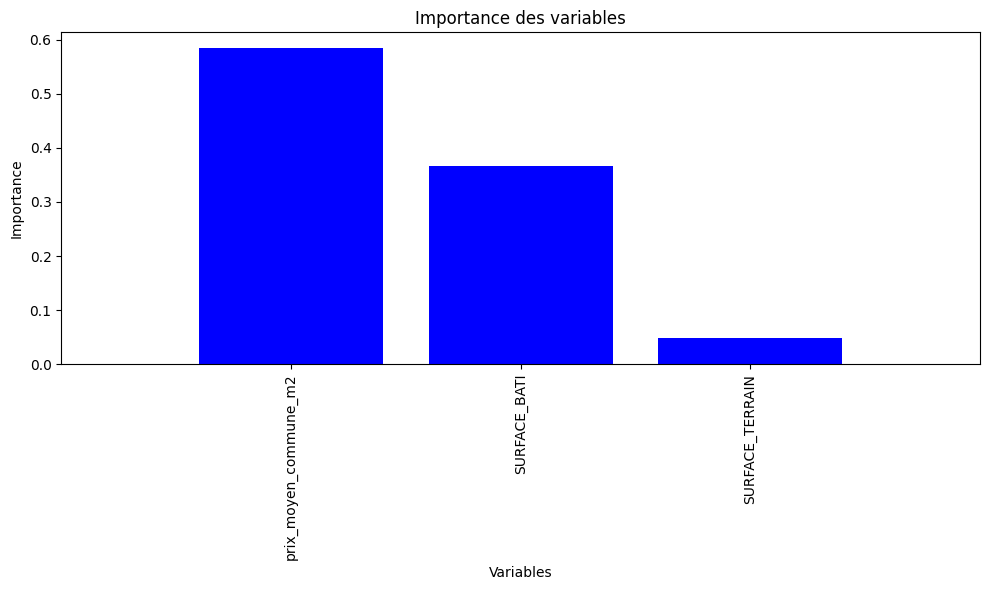

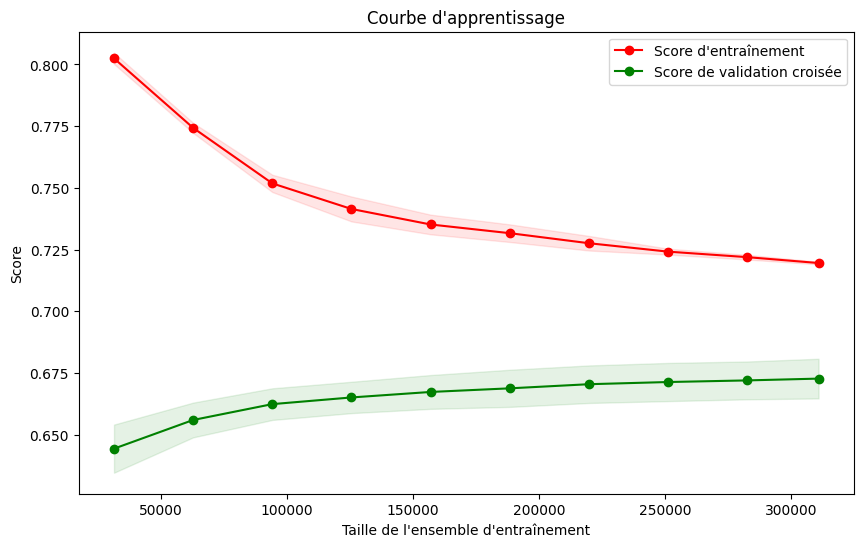

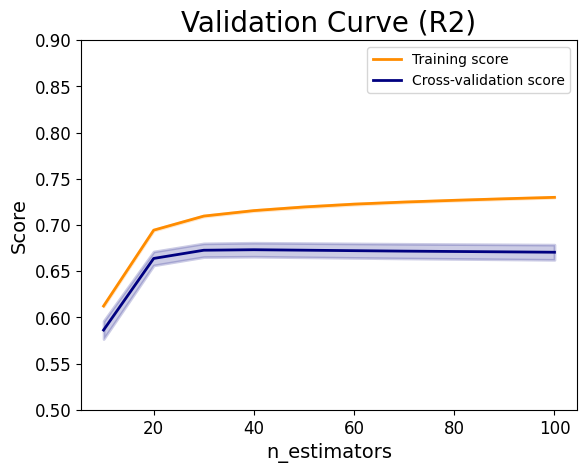

Entraînement OK
Log du modèle et des artifacts en cours...


Successfully registered model 'XGB__Maison_15months_GridSearch_GestionOutliers_oui_surface_terrain_alpha_lambda'.
2024/02/18 21:31:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGB__Maison_15months_GridSearch_GestionOutliers_oui_surface_terrain_alpha_lambda, version 1
Created version '1' of model 'XGB__Maison_15months_GridSearch_GestionOutliers_oui_surface_terrain_alpha_lambda'.


In [20]:
X_train,y_train, X_test, y_test = split_with_m2(df)

X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

model, best_params = train_model_xgboost(X_train,y_train, param_grid, cv)

# Tracé et enregistrement du graphique permettant de savoir si le modèle contient suffisamment de données.
images = plot_validation_learning_curve(model, X_train, y_train)

param_mlflow(uri_tracking=uri_tracking,
        experiment_name=experiment_name, run_name=run_name,
        best_params=best_params,
        model=model, model_name=model_name,
        X_test=X_test, y_test=y_test,
        encoders=encoders,scalers=scalers,
        images = images).log_mlflow()

